---
# Apical vs Latéral

Nous regroupons ici nos analyses sur les différences entre les branches apicales et les branches latérales.

Tout d'abord, chargeons les différents réseaux considérés. Il s'agit ici des trois mycéliums sauvages en conditions standards.

In [1]:
#Les bibliothèques classiques
import matplotlib.pyplot as plt #To make figure
plt.rcParams.update({'font.size':12})#To make figure readable
import numpy as np #For everything
import networkx as nx #To open the graph
from tqdm import tqdm #For nice loading bars
from scipy.optimize import curve_fit
#Et nos propres fichiers
from declaration import load
from Reseau import Reseau,Branche
from fct_utils import prune
reseaux_name = [
    "M2WT_200610",
    "M2WT_200616",
    "M2WT_200617"
]
reseaux_before_overlaps = [load(name,"branched") for name in reseaux_name]
reseaux_after_overlaps = [load(name,"overlaps") for name in reseaux_name]

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/alice/HyphalNetwork/M2WT/20_06_10_P_S_M2_output/M2WT_200610_branched.gpickle'

In [2]:
mesures = {}
for r in reseaux_after_overlaps:
    spore = r.source
    pos_spore = np.array([r.n2x[spore],r.n2y[spore]])
    t0 = np.array([b.get_tstart() for b in r.branches])
    Deltat = t0 - np.array([r.n2t[b.noeuds[0]] for b in r.branches])
    R = np.sqrt(np.sum((np.array([[r.n2x[b.noeuds[0]],r.n2y[b.noeuds[0]]] for b in r.branches])-pos_spore)**2,axis=-1))
    theta = np.arctan2([r.n2y[b.noeuds[0]]-pos_spore[1] for b in r.branches],[r.n2x[b.noeuds[0]]-pos_spore[0] for b in r.branches])
    Rmax = {t:np.sqrt(np.max(np.sum((np.array([[r.n2x[a],r.n2y[a]] for a,d in r.network_at(t).degree() if d == 1])-pos_spore)**2,axis=-1))) for t in range(r.start,r.end+1)}
    mesures[r.name] = {
        't0': t0,
        'Deltat': Deltat,
        'R':R,
        'theta':theta,
        'Rmax':Rmax
    }

## Figures Article

In [3]:
labels = ['(A)','(B)','(C)','(A)+(B)+(C)']
colors = ["chartreuse","turquoise","darkgreen","cyan"]#["blue","lightblue","deepskyblue","chartreuse"]

## Distinction between degree 3 vertices

In [4]:
for r in reseaux_after_overlaps:
    #we need for each time the number of branching point, encounters, d1, overlaps.
    times = list(range(r.start,r.end+1))
    branching_pts = np.zeros_like(times)
    encounters = np.zeros_like(times)
    d1 = np.zeros_like(times)
    overlaps = np.zeros_like(times)
    bstart = [b.get_tstart() for b in r.branches]
    for k,t in enumerate(times):
        g = r.network_at(t)
        d1[k] = sum(d==1 for n,d in g.degree())
        branching_pts[k] = sum(t0<=t for t0 in bstart)
        encounters[k] = branching_pts[k]-d1[k]
        overlaps[k] = sum(n<0 for n in g.nodes)
    mesures[r.name]["counts"] = [branching_pts,encounters,d1,overlaps]

In [5]:
from scipy.stats import t as Student
def confidence_band(xx,yy,confidence=0.95):
    n = len(yy)
    xmean = np.mean(xx)
    ymean = np.mean(yy)
    sx2 = 1/(n-1)*np.sum((xx-xmean)**2)
    sy2 = 1/(n-1)*np.sum((yy-ymean)**2)
    sxy = 1/(n-1)*np.sum((xx-xmean)*(yy-ymean))
    R2 = sxy**2/(sx2*sy2)
    syoverx = np.sqrt(sy2*(1-R2))
    sigma = syoverx*np.sqrt(n/(n-2))
    t = Student.interval(confidence,df=n-2)[-1]
    b1 = sxy/sx2 
    b0 = ymean-b1*xmean
    y = lambda x: b0+b1*x
    dy = lambda x : t*sigma*np.sqrt(1/n+(x-xmean)**2/np.sum((xx-xmean)**2))
    return y, dy

def prediction_band(xx,yy,confidence=0.95):
    n = len(yy)
    xmean = np.mean(xx)
    ymean = np.mean(yy)
    sx2 = 1/(n-1)*np.sum((xx-xmean)**2)
    sy2 = 1/(n-1)*np.sum((yy-ymean)**2)
    sxy = 1/(n-1)*np.sum((xx-xmean)*(yy-ymean))
    R2 = sxy**2/(sx2*sy2)
    syoverx = np.sqrt(sy2*(1-R2))
    sigma = syoverx*np.sqrt(n/(n-2))
    t = Student.interval(confidence,df=n-2)[-1]
    b1 = sxy/sx2 
    b0 = ymean-b1*xmean
    y = lambda x: b0+b1*x
    dy = lambda x : t*sigma*np.sqrt(1+1/n+(x-xmean)**2/np.sum((xx-xmean)**2))
    return y, dy


## $r(t_0) = R(t_0)/R_{max}(t_0)$  

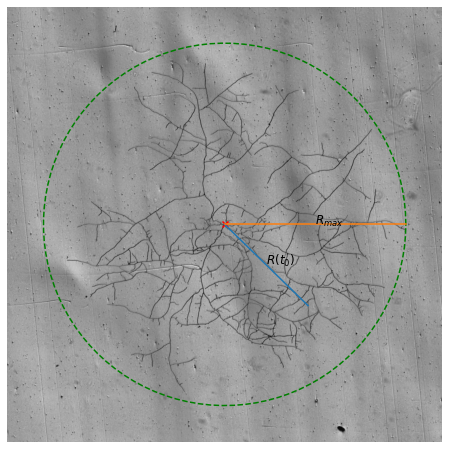

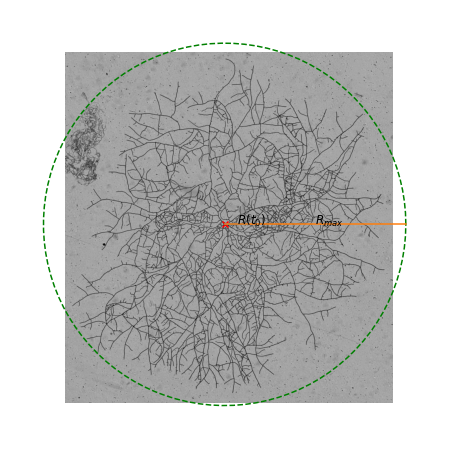

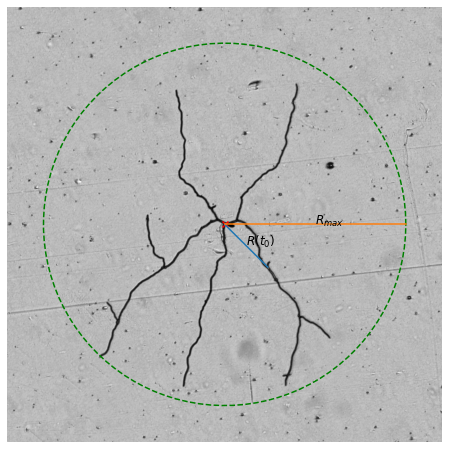

In [6]:
#Essayons de représenter r = R(t0)/Rmax(t0) en considérant une image du réseau à t_0 en représentant R(t0) et Rmax(t0)
for k,r in enumerate(reseaux_after_overlaps):
    spore = r.source
    xs,ys = r.n2x[spore],r.n2y[spore]
    boi = np.random.choice(r.branches,size=1)[0]
    xoi,yoi = boi.x[0],boi.y[0]
    t0 = boi.get_tstart()
    Rmax = mesures[r.name]["Rmax"][t0]
    fig,ax = plt.subplots(figsize=(8,8))
    ax.imshow(r.image_at(t0),cmap="Greys")
    ax.axis("off")
    ax.scatter(xs,ys,marker="x",color="red")
    theta = np.linspace(0,2*np.pi,100)
    ax.plot(xs+Rmax*np.cos(theta),ys+Rmax*np.sin(theta),ls="dashed",color="green")
    ax.plot([xs,xoi],[ys,yoi])
    ax.plot([xs,xs+Rmax],[ys,ys])
    ax.text(xs+Rmax*.5,ys,"$R_{max}$")
    ax.text((xs+xoi)*.5,(ys+yoi)*.5,"$R(t_0)$")
    ax.set_xlim([xs-1.2*Rmax,xs+1.2*Rmax])
    ax.set_ylim([ys-1.2*Rmax,ys+1.2*Rmax])
    fig.savefig(f"/Users/thibault/Documents/Thèse/AnalyseReseau/M2WT/example_r_{k}.png",dpi=300)
    plt.show()
    plt.close()



0.08550805037019016 0.3309772552972496
0.2738717912657793 1.4370744993411144


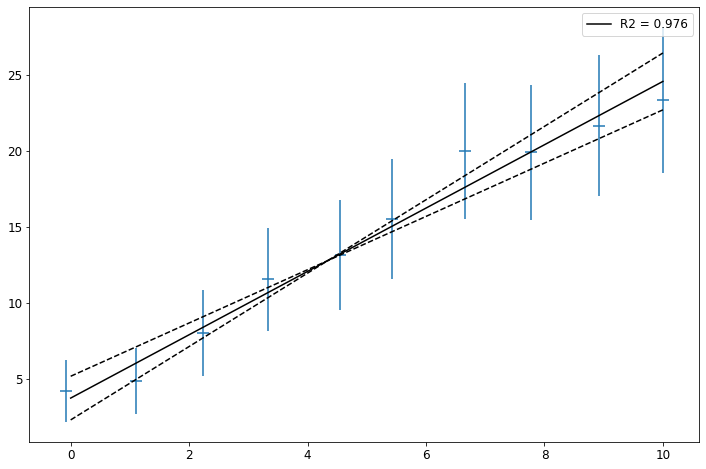

In [7]:

def linear_regression(x,y,dx,dy):
    """ 
    Linear regression of the form y = ax+b
    return (a,b,da,db),R2
    """
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    xy_mean = np.mean(x*y)
    x2_mean = np.mean(x**2)
    a0 = (xy_mean-x_mean*y_mean)/(x2_mean-x_mean**2)
    b0 = y_mean-a0*x_mean 
    w = 1/(dy**2+(a0*dx)**2)
    Delta = np.sum(w)*np.sum(w*x*x)-np.sum(w*x)**2
    a = (np.sum(w)*np.sum(w*x*y)-np.sum(w*x)*np.sum(w*y))/Delta
    b = (np.sum(w*y)*np.sum(w*x*x)-np.sum(w*x)*np.sum(w*x*y))/Delta
    da = np.sqrt(np.sum(w)/Delta)
    db = np.sqrt(np.sum(w*x*x)/Delta)
    R2 = 1-np.sum((y-a*x-b)**2)/np.sum((y-y_mean)**2)
    return (a,b,da,db),R2

npts = 10
a_t,b_t = 2,4
sig_x,sig_y = 0.1,1
x_test = np.linspace(0,10,npts)+sig_x*np.random.randn(npts)
y_test = a_t*x_test+b_t*np.ones(npts)+sig_y*np.random.randn(npts)
err_x = sig_x*np.ones(npts)
err_y = np.sqrt(y_test)
param,R2 = linear_regression(x_test,y_test,err_x,err_y)
a,b,da,db = param
fig,ax = plt.subplots(figsize=(12,8))
ax.errorbar(x_test,y_test,xerr=err_x,yerr=err_y,ls=" ")
x = np.linspace(0,10)
ax.plot(x,a*x+b,'k',label=f"R2 = {R2:.3f}")
ax.plot(x,(a+da)*x+b-db,'k--')
ax.plot(x,(a-da)*x+b+db,'k--')
ax.legend()
print(np.abs(a_t-a),da)
print(np.abs(b_t-b),db)
plt.show()
plt.close()

In [8]:
for r in tqdm(reseaux_after_overlaps):
    L = np.zeros(r.end-r.start+1)
    for k,t in tqdm(enumerate(range(r.start,r.end+1))):
        g = r.network_at(t)
        L[k] = np.sum(np.sqrt([(r.n2x[v]-r.n2x[u])**2+
                               (r.n2y[v]-r.n2y[u])**2 
                               for u,v in g.edges]))
    mesures[r.name]["L"] = L

60it [01:28,  1.47s/it]0:00<?, ?it/s]
55it [00:51,  1.07it/s]1:28<02:56, 88.06s/it]
56it [01:01,  1.11s/it]2:19<01:06, 66.37s/it]
100%|██████████| 3/3 [03:21<00:00, 67.07s/it]


In [9]:
def sigmoid(x,m,s):
    return 1/(1+np.exp(-(x-m)/s))

def line(x,m,p):
    return m*x+p

M2WT_200610

Theta_A 0.1618334007387776 0.012796470935988753
tau_A 0.1028661759990701 0.008390098334164967
omega_A 2.6889607185936 0.23469822252618192
Theta_L 0.4142316703697703 0.03252879371023582
tau_L 10.344824589650353 0.8511523685675364
m 100.80118648763228 6.967242400277537
s 11.934301547359322 6.0114745827369624
Delta t_AL	 76.93+/-13.52
M2WT_200616

Theta_A 0.15883516561876676 0.01658128229770323
tau_A 0.11112583625550623 0.012330592593055627
omega_A 2.1564862909828157 0.24654671687071086
Theta_L 0.5363038567587372 0.06028627290101343
tau_L 9.577706768884342 1.137455500626782
m 112.3634009589554 7.553952766070163
s 7.220561273135665 6.529345928072636
Delta t_AL	 97.92+/-13.67
M2WT_200617

Theta_A 0.08939947416312716 0.007790445723174351
tau_A 0.12648236443380556 0.013646869681435997
omega_A 2.184494013287841 0.21926472888445148
Theta_L 0.36599587161378844 0.03269605396022279
tau_L 11.334047875829231 1.0827832522540886
m 105.1093872739278 7.177896380824603
s 10.343589547251971 6

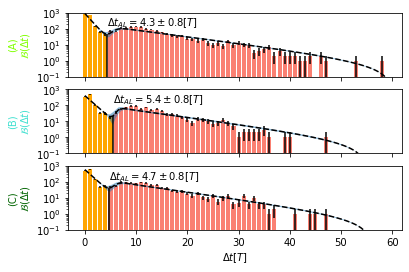

In [10]:
plt.rcParams.update({'font.size':10})#To make figure readable
fig,axes = plt.subplots(figsize=(6,4),nrows=3)
axes[0].sharex(axes[1])
axes[0].tick_params('x', labelbottom=False)
axes[1].sharex(axes[2])
axes[1].tick_params('x', labelbottom=False)
names = ["A","B","C"]
fit_latency = []
for k,r in enumerate(reseaux_after_overlaps):
    Dt = mesures[r.name]["Deltat"]
    bins= np.arange(0,r.end-r.start+1)
    L = mesures[r.name]["L"]
    logL = np.log2(L)
    ti = np.arange(r.start,r.end+1)
    f = np.where(ti>=20)
    popt_L,pcov_L = curve_fit(line,ti[f],logL[f],sigma=1/(np.log(2)*np.sqrt(L[f]))) 
    #param,R2=linear_regression(ti[f],logL[f],np.ones_like(ti[f]),1/np.sqrt(L[f]))
    lambda_,logL0 = popt_L
    dlogL0 = np.sqrt(pcov_L[1,1])
    t0 = mesures[r.name]["t0"]
    N = np.array([np.sum(t0<=t) for t in range(r.start,r.end+1)])
    log2N = np.log2(N)
    popt_N, pcov_N = curve_fit(line,ti,log2N,sigma=1/(np.log(2)*np.sqrt(N)))
    nu,log2N0 = popt_N
    dlog2N0 = np.sqrt(pcov_N[1,1])
    #(nu,log2N0,dnu,dlog2N0),R2 = linear_regression(ti,log2N,np.ones_like(ti),1/np.sqrt(N))
    delt = 1
    L0 = 2**logL0
    DeltaN = (2**(nu*r.end)-2**(nu*(r.start-1)))/(1-2**(-nu))
    def N_total(Deltat:float,Theta_A:float,omega_A:float,Theta_L:float,m:float,s:float)->float:
        NA = Theta_A*DeltaN*omega_A*np.exp(-omega_A*Deltat)
        NL = Theta_L*sigmoid(Deltat,m,s)
        NL = NL*(2**(lambda_*(r.end-Deltat))-2**(lambda_*(r.start-1)))
        return NA+NL
    
    N = len(Dt)
    hist,_ = np.histogram(Dt,bins=bins)
    popt,pcov = curve_fit(N_total,bins[:-1],hist,bounds=[[0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf]],p0=[1,1,1,10,1],sigma=np.where(hist>0,np.sqrt(hist),1))
    fit_latency.append((popt,pcov))
    print("="*80)
    print(f"{r.name}\n")
    print("Theta_A",popt[0],np.sqrt(pcov[0,0]))
    tau_A = popt[0]/(2**log2N0*18)*60
    print("tau_A",tau_A, tau_A*np.sqrt(pcov[0,0]/popt[0]**2+(np.log(2)*dlog2N0)**2))
    print("omega_A",popt[1]/18*60,np.sqrt(pcov[1,1])/18*60)
    print("Theta_L",popt[2],np.sqrt(pcov[2,2]))
    tau_L = popt[2]/(L0*18*1.6)*60*10e3
    print("tau_L",tau_L,tau_L*np.sqrt(pcov[2,2]/popt[2]**2+(np.log(2)*dlogL0)**2))
    print("m",popt[3]*18,np.sqrt(pcov[3,3])*18)
    print("s",popt[4]*18,np.sqrt(pcov[4,4])*18)
    Deltat_AL = popt[3]-2*popt[4]
    sig_AL = np.sqrt(pcov[3,3]+4*pcov[4,4]-2*pcov[3,4])

    print(f"Delta t_AL\t {Deltat_AL*18:.2f}+/-{sig_AL*18:.2f}")
    def dB(Deltat:float,popt,pcov)->float:
        #A reprendre avec la bonne expression de Theta_A
        ThetaA, omegaA, ThetaL,m,s = popt
        dB2 = np.exp(-2*Deltat*omegaA)*(pcov[0,0]+(Deltat*ThetaA)**2*pcov[1,1]-ThetaA*Deltat*pcov[0,1])
        S_temp = sigmoid(Deltat,m,-s)/s
        temp = (Deltat-m)/s
        F2 = (2**(lambda_*(r.end-Deltat))-2**(lambda_*(r.start+1)))**2
        dB2 += F2*ThetaL**2*sigmoid(Deltat,m,s)**2*(
            pcov[2,2]/(ThetaL**2)+
            S_temp**2*pcov[3,3]+
            temp**2*S_temp**2*pcov[4,4]+
            S_temp*pcov[2,3]/ThetaL+
            temp*S_temp*pcov[2,4]/ThetaL+
            temp*S_temp**2*pcov[3,4]
        )
        return np.sqrt(dB2)

    Deltat_AL = popt[3]-2*popt[4]
    ax = axes[k]
    xx = bins[:-1]
    f  = np.where(xx<Deltat_AL)
    nf = np.where(xx>=Deltat_AL)
    ax.bar(xx[f],hist[f],yerr=np.sqrt(hist[f]),color="orange")
    ax.bar(xx[nf],hist[nf],yerr=np.sqrt(hist[nf]),color="salmon")
    ax.annotate(text="$\Delta t_{AL} = $"+f"${Deltat_AL:.1f}\pm{sig_AL:.1f} [T]$",
                xy = (Deltat_AL,1.5*10**2))
    xx = np.linspace(0,bins[-1],100)
    ax.plot(xx,N_total(xx,*popt),"k--")
    t = 1
    ax.fill_between(xx,N_total(xx,*popt)+t*dB(xx,popt,pcov),N_total(xx,*popt)-t*dB(xx,popt,pcov),alpha=0.5)
    ax.vlines(Deltat_AL,1e-2,N_total(Deltat_AL,*popt),colors="black")
    ax.set_ylim(1e-1,1e3)
    ax.set_yscale("log")
    ax.set_ylabel(f"({names[k]})"+"\n$\mathcal{B}(\Delta t)$",color=colors[k])
axes[2].set_xlabel("$\Delta t [T]$")
fig.savefig(f"/Users/thibault/Documents/Thèse/AnalyseReseau/M2WT/latency_triplicat.png",dpi=300)
plt.show()
plt.close()


4.801427221944844 0.7625005040079027


/Users/thibault/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/thibault/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/thibault/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/thibault/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/thibault/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


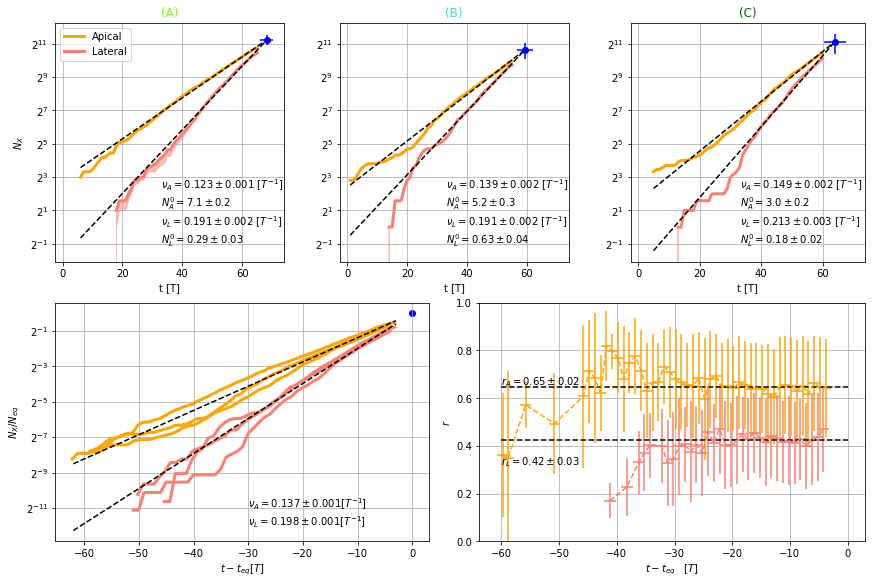

In [11]:
Deltat_AL = np.mean([popt[3]-2*popt[4] for popt,pcov in fit_latency])
dDeltat_AL = np.mean([np.sqrt(pcov[3,3]+4*pcov[4,4])-2*pcov[3,4]])
print(Deltat_AL,dDeltat_AL)
fig,axes = plt.subplot_mosaic([["A","A","B","B","C","C"],
                               ["N/Neq","N/Neq","N/Neq","r","r","r"]],
                               figsize=(12,8),constrained_layout=True)
axes["A"].sharex(axes["B"])
axes["B"].sharex(axes["C"])
axes["A"].sharey(axes["B"])
axes["B"].sharey(axes["C"])
teqs = []
dteqs = []
Neqs = [] 
dNeqs = []
rtn  = []
fits = []
names=["A","B","C"]
for k,r in enumerate(reseaux_after_overlaps):
    x0,y0 = r.n2x[r.source],r.n2y[r.source]
    apical = []
    lateral = []
    apicalp = []
    apicalm = []
    lateralp = []
    lateralm = []
    for b in r.branches:
        b.n2x = r.n2x
        b.n2y = r.n2y
        b.n2t = r.n2t
        t0 = b.get_tstart()
        Deltat = t0-r.n2t[b.noeuds[0]]
        b.nature = "Apical" if (Deltat<Deltat_AL) else "Lateral"
        List = apical if b.nature == "Apical" else lateral
        List.append(t0)
        List = apicalp if Deltat<Deltat_AL+dDeltat_AL else lateralp
        List.append(t0)
        List = apicalm if Deltat<Deltat_AL-dDeltat_AL else lateralm
        List.append(t0)
    ax = axes[names[k]]
    tt = np.arange(r.start,r.end+1)
    count_api = np.array([np.sum([t0<=t for t0 in apical]) for t in tt])
    count_apip = [np.sum([t0<=t for t0 in apicalp]) for t in tt]
    count_apim = [np.sum([t0<=t for t0 in apicalm]) for t in tt]
    count_lat = np.array([np.sum([t0<=t for t0 in lateral]) for t in tt])
    count_latp = [np.sum([t0<=t for t0 in lateralp]) for t in tt]
    count_latm = [np.sum([t0<=t for t0 in lateralm]) for t in tt]
    log2_api = np.log2(count_api)
    popt_A,pcov_A = curve_fit(line,tt,log2_api,sigma=1/(np.log(2)*np.sqrt(count_api)))
    nu_A,log2_N0A = popt_A
    dnu_A,dlog2_N0A = np.sqrt([pcov_A[i,i] for i in range(2)])
    #(nu_A,log2_N0A,dnu_A,dlog2_N0A),R2_A = linear_regression(tt,log2_api,dx=1,dy=1/(np.log(2)*np.sqrt(count_api)))
    
    f = np.where(count_lat>0)
    log2_lat = np.log2(count_lat[f])
    popt_L,pcov_L = curve_fit(line,tt[f],log2_lat,sigma=1/(np.log(2)*np.sqrt(count_lat[f])))
    nu_L,log2_N0L = popt_L
    dnu_L,dlog2_N0L = np.sqrt([pcov_L[i,i] for i in range(2)])
    #(nu_L,log2_N0L,dnu_L,dlog2_N0L),R2_L = linear_regression(tt[f],log2_lat,dx=1,dy=1/(np.log(2)*np.sqrt(count_lat[f])))
    fits.append([[popt_A,pcov_A],
                 [popt_L,pcov_L]])
    teq = - (log2_N0L-log2_N0A)/(nu_L-nu_A)
    dteq = np.sqrt((nu_A-nu_L)**(-2)*(pcov_L[1,1]+pcov_A[1,1]+
                                      (pcov_L[0,1]+pcov_A[0,1])*teq+
                                      (pcov_L[0,0]+pcov_A[0,0])*teq**2))
    Neq = 2**(nu_A*teq+log2_N0A)
    dNeq = np.log(2)*Neq*np.sqrt((nu_A-nu_L)**(-2))
    dNeq = dNeq*np.sqrt((nu_L**2*pcov_A[1,1]+nu_A**2*pcov_L[1,1])+
                        (nu_L**2*pcov_A[0,1]+nu_A**2*pcov_L[0,1])*teq+
                        (nu_L**2*pcov_A[0,0]+nu_A**2*pcov_L[0,0])*teq**2)

    teqs.append(teq)
    dteqs.append(dteq)
    Neqs.append(Neq)
    dNeqs.append(dNeq)
    t_fit = np.linspace(r.start,teq,2)
    ax.errorbar(teq,Neq,xerr=dteq,yerr=dNeq,marker="o",color="blue")
    ax.plot(tt,count_api,lw=3,c="orange",label="Apical")
    ax.plot(t_fit,2**(nu_A*t_fit+log2_N0A),'k--')
    ax.fill_between(tt,count_apip,count_apim,color="orange",alpha=0.5)
    ax.plot(tt[f],count_lat[f],lw=3,c="salmon",label="Lateral")
    ax.plot(t_fit,2**(nu_L*t_fit+log2_N0L),'k--')
    ax.fill_between(tt,count_latp,count_latm,color="salmon",alpha=0.5)
    ax.set_yscale("log",base=2)
    ax.annotate(text=f"$\\nu_A = {nu_A:.3f}\pm{dnu_A:.3f}$"+" $[T^{-1}]$\n"+
                f"$N_A^0 = {2**log2_N0A:.1f}\pm{2**log2_N0A*np.log(2)*dlog2_N0A:.1f}$\n"+
                f"$\\nu_L = {nu_L:.3f}\pm{dnu_L:.3f}$"+" $[T^{-1}]$\n"+
                f"$N_L^0 = {2**log2_N0L:.2f}\pm{2**log2_N0L*np.log(2)*dlog2_N0L:.2f}$",
                xy=(33,1/2))
    #ax.set_ylabel("$N_X$")
    ax.set_title(f"({names[k]})",color=colors[k])
    ax.grid()
    ax.set_xlabel("t [T]")
    ax = axes["N/Neq"]
    ax.plot(tt-teq,count_api/Neq,c="orange",lw=3)
    ax.plot(tt[f]-teq,count_lat[f]/Neq,c="salmon",lw=3)
    Rmax = mesures[r.name]["Rmax"]
    for b in r.branches:
        t0 = b.get_tstart()
        rtn.append([np.sqrt((b.x[0]-x0)**2+(b.y[0]-y0)**2)/Rmax[int(t0)],t0-teq,int(b.nature=="Apical")])
rtn = np.array(rtn)
nu_A = np.mean([fit[0][0][0] for fit in fits])
dnu_A = np.sqrt(np.sum([fit[0][1][0,0] for fit in fits]))/3
nu_L = np.mean([fit[1][0][0] for fit in fits])
dnu_L = np.sqrt(np.sum([fit[1][1][0,0] for fit in fits]))/3
ax = axes["N/Neq"]
ttilde = np.arange(int(np.min(rtn[:,1])),int(np.max(rtn[:,1]))+1)
ax.plot(ttilde,2**(nu_A*ttilde),'k--')
ax.plot(ttilde,2**(nu_L*ttilde),'k--')
ax.annotate(text=f"$\\nu_A = {nu_A:.3f}\pm{dnu_A:.3f}$"+"$[T^{-1}]$\n"+
            f"$\\nu_L = {nu_L:.3f}\pm{dnu_L:.3f}$"+"$[T^{-1}]$",
            xy=(-30,2**(-12)))
ax.scatter(0,1,marker="o",color="blue")
ax.set_yscale("log",base=2)
ax.set_ylabel("$N_X/N_{eq}$")
ax.set_xlabel("$t-t_{eq} [T]$")
ax.grid()
axes["A"].legend()
axes["A"].set_ylabel("$N_X$")
msn_api = np.zeros((int(np.max(rtn[:,1]))-int(np.min(rtn[:,1]))+1,3))
msn_lat = np.zeros((int(np.max(rtn[:,1]))-int(np.min(rtn[:,1]))+1,3))
for j,t in enumerate(ttilde):
    f_t = np.logical_and(rtn[:,1]>= t,rtn[:,1]<(t+1))
    api = rtn[:,2] == 1
    filtre = np.where(np.logical_and(f_t,api)) 
    l = rtn[filtre][:,0]
    msn_api[j,:] = np.mean(l),np.std(l),len(l)
    filtre = np.where(np.logical_and(f_t,~api)) 
    l = rtn[filtre][:,0]
    msn_lat[j,:] = np.mean(l),np.std(l),len(l)
ax = axes["r"]
f = np.where(msn_api[:,2]>2**2)
ax.errorbar(ttilde[f]+.2,msn_api[f][:,0],yerr=msn_api[f][:,1],xerr=1,ls="--",color="orange")
f = np.where(msn_lat[:,2]>2**2)
ax.errorbar(ttilde[f]-.2,msn_lat[f][:,0],yerr=msn_lat[f][:,1],xerr=1,ls="--",color="salmon")
f = np.where(ttilde>-30)
r_api = np.mean(msn_api[f][:-1,0])
dr_api = np.std(msn_api[f][:-1,0])
r_lat = np.mean(msn_lat[f][:-1,0])
dr_lat = np.std(msn_lat[f][:-1,0])
ax.hlines([r_api,r_lat],xmin=[-60,-60],xmax=[0,0],colors=["black","black"],linestyles="dashed")
ax.annotate(text=f"$r_A = {r_api:.2f}\pm{dr_api:.2f}$",
            xy=(-60,r_api+0.01))
ax.annotate(text=f"$r_L = {r_lat:.2f}\pm{dr_lat:.2f}$",
            xy=(-60,r_lat-0.1))
#axes[1,1].fill_between(ttilde[f],q0s[f],q1s[f],colors="orange",alpha=.1)
ax.set_ylim(0,1)
ax.grid()
ax.set_ylabel("$r$")
ax.set_xlabel("$t - t_{eq}\quad[T]$")
fig.savefig(f"/Users/thibault/Documents/Thèse/AnalyseReseau/M2WT/count_ApicalLateral.png",dpi=300)
plt.show()
plt.close()

M2WT_200610
Branching
points
a = 0.145+/-0.002
N0 = 4.843+/-0.275
Encounters
a = 0.160+/-0.002
N0 = 1.240+/-0.103
Free
apexes
a = 0.134+/-0.002
N0 = 4.122+/-0.252
Overlaps
a = 0.149+/-0.003
N0 = 0.491+/-0.058
M2WT_200616
Branching
points
a = 0.160+/-0.002
N0 = 4.404+/-0.280
Encounters
a = 0.197+/-0.005
N0 = 0.572+/-0.077
Free
apexes
a = 0.142+/-0.002
N0 = 4.542+/-0.290
Overlaps
a = 0.208+/-0.009
N0 = 0.099+/-0.028
M2WT_200617
Branching
points
a = 0.167+/-0.002
N0 = 2.480+/-0.165
Encounters
a = 0.211+/-0.004
N0 = 0.239+/-0.030
Free
apexes
a = 0.146+/-0.002
N0 = 2.763+/-0.190
Overlaps
a = 0.220+/-0.006
N0 = 0.052+/-0.012


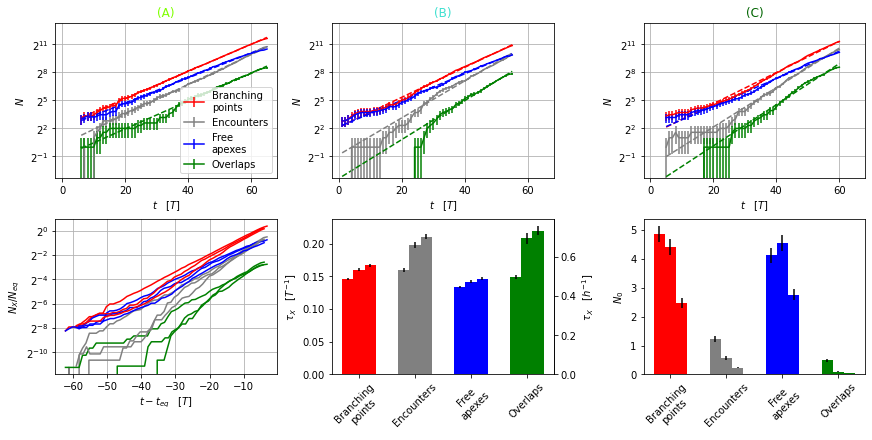

In [12]:
labels_count=["Branching\npoints","Encounters","Free\napexes", "Overlaps"]
colors_count=["red","gray","blue","green"]
fig,axes = plt.subplot_mosaic([["A","B","C"],
                               ["norm","param_tau","param_N0"]],
                               figsize=(12,6),constrained_layout=True)
axes["A"].sharex(axes["B"])
axes["B"].sharex(axes["C"])
names = ["A","B","C"]
for k,r in enumerate(reseaux_after_overlaps):
    counts = mesures[r.name]["counts"]
    ax = axes[names[k]]
    tt = np.arange(r.start,r.end+1)
    print("="*80)
    print(r.name)
    ax.set_yscale("log",base=2)
    ax.set_title("("+names[k]+")",color=colors[k])
    ax.set_ylabel("$N$")
    ax.grid()
    ax.set_xlabel("$t\quad [T]$")
    ax.set_ylim(1e-1,1e4)

    teq = teqs[k]
    Neq = Neqs[k]
    for i,count in enumerate(counts):
        f = np.where(count>0)
        ln2_count = np.log2(count[f])
        
        (a,b,da,db),R2 = linear_regression(tt[f],ln2_count,dx=1,dy=1/(np.log(2)*np.sqrt(count[f])))
        ax = axes[names[k]]
        ax.errorbar(tt,count,yerr=np.sqrt(count),label=labels_count[i],color=colors_count[i])
        ax.plot(tt,2**(a*tt+b),color=colors_count[i],ls="--")
        print(labels_count[i])
        print(f"a = {a:.3f}+/-{da:.3f}")
        print(f"N0 = {2**b:.3f}+/-{2**b*np.log(2)*db:.3f}")
        ax = axes["param_tau"]
        ax.bar(i-.3+k*.2,a,yerr=da,color=colors_count[i],width=.2,align="edge")
        ax = axes["param_N0"]
        ax.bar(i-.3+k*.2,2**b,yerr=2**b*np.log(2)*db,color=colors_count[i],width=.2,align="edge")
        ax = axes["norm"]
        ax.errorbar(tt-teq,count/Neq,color=colors_count[i])
axes["norm"].set_yscale("log",base=2)
axes["norm"].set_ylabel("$N_X/N_{eq}$")
axes["norm"].set_xlabel("$t-t_{eq} \quad [T]$")
axes["norm"].grid()
def convert_frame2h(frame):
    return frame*18/60
def convert_h2frame(min):
    return min/18*60
axes["param_N0"].set_ylabel("$N_0$")
axes["param_N0"].set_xticks(range(4),labels_count,rotation=45)
axes["param_tau"].set_ylabel("$\\tau_X\quad [T^{-1}]$")
sec_ax = axes["param_tau"].secondary_yaxis("right",functions=(convert_h2frame,convert_frame2h))
sec_ax.set_ylabel("$\\tau_X\quad [h^{-1}]$")
axes["param_tau"].set_xticks(range(4),labels_count,rotation=45)
axes["A"].legend()
fig.savefig(f"/Users/thibault/Documents/Thèse/AnalyseReseau/M2WT/count_triplicat.png",dpi=300)
plt.show()
plt.close()

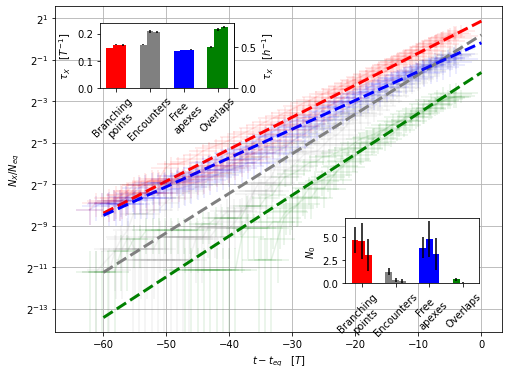

In [13]:
labels_count=["Branching\npoints","Encounters","Free\napexes", "Overlaps"]
colors_count=["red","gray","blue","green"]
fig,ax_norm = plt.subplots(figsize=(8,6))
ax_param_tau = ax_norm.inset_axes([0.1,0.75,0.3,0.2])
ax_param_N0 = ax_norm.inset_axes([0.65,0.15,0.3,0.2])
names = ["A","B","C"]
fits = {label:[] for label in labels_count}
for k,r in enumerate(reseaux_after_overlaps):
    counts = mesures[r.name]["counts"]
    tt = np.arange(r.start,r.end+1)
    teq = teqs[k]
    dteq = dteqs[k]
    Neq = Neqs[k]
    dNeq = dNeqs[k]
    for i,count in enumerate(counts):
        label = labels_count[i]
        f = np.where(count>0)
        ln2_count = np.log2(count[f]/Neq)
        sigma = np.sqrt(1/count[f]+(dNeq/Neq)**2)/np.log(2)
        popt,pcov = curve_fit(line,tt[f]-teq,ln2_count,sigma=sigma)
        fits[label].append([popt,pcov])
        a,b = popt
        da,db = np.sqrt([pcov[i,i] for i in range(2)])
        #(a,b,da,db),R2 = linear_regression(tt[f],ln2_count,dx=1,dy=1/(np.log(2)*np.sqrt(count[f])))
        ax = ax_param_tau
        ax.bar(i-.3+k*.2,a,yerr=da,color=colors_count[i],width=.2,align="edge")
        ax = ax_param_N0
        N0 = Neq*2**(b-a*teq)
        sig_N0 = N0*np.sqrt((dNeq/Neq)**2+np.log(2)**2*(db**2+(teq*da)**2+(a*dteq)**2-teq*pcov[0,1]))
        ax.bar(i-.3+k*.2,N0,yerr=sig_N0,color=colors_count[i],width=.2,align="edge")
        ax = ax_norm
        ax.errorbar(tt[f]-teq,count[f]/Neq,color=colors_count[i],xerr=dteq,yerr=count[f]/Neq*np.sqrt(1/count[f]+(dNeq/Neq)**2),alpha=0.1)
tt = np.linspace(-60,0,2)
k = 0
for count,fit in fits.items():
    m = np.mean([fit[i][0][0] for i in range(3)])
    p = np.mean([fit[i][0][1] for i in range(3)])
    sig_m = np.sqrt(np.sum([fit[i][1][0,0] for i in range(3)]))/3
    sig_p = np.sqrt(np.sum([fit[i][1][1,1] for i in range(3)]))/3
    ax_norm.plot(tt,2**(m*tt+p),color=colors_count[k],ls='--',lw=3)
    k += 1
ax_norm.set_yscale("log",base=2)
ax_norm.set_ylabel("$N_X/N_{eq}$")
ax_norm.set_xlabel("$t-t_{eq} \quad [T]$")
ax_norm.grid()
def convert_frame2h(frame):
    return frame*18/60
def convert_h2frame(min):
    return min/18*60
ax_param_N0.set_ylabel("$N_0$")
ax_param_N0.set_xticks(range(4),labels_count,rotation=45)
ax_param_tau.set_ylabel("$\\tau_X\quad [T^{-1}]$")
sec_ax = ax_param_tau.secondary_yaxis("right",functions=(convert_h2frame,convert_frame2h))
sec_ax.set_ylabel("$\\tau_X\quad [h^{-1}]$")
ax_param_tau.set_xticks(range(4),labels_count,rotation=45)
fig.savefig(f"/Users/thibault/Documents/Thèse/AnalyseReseau/M2WT/count_triplicat.png",dpi=300)
plt.show()
plt.close()

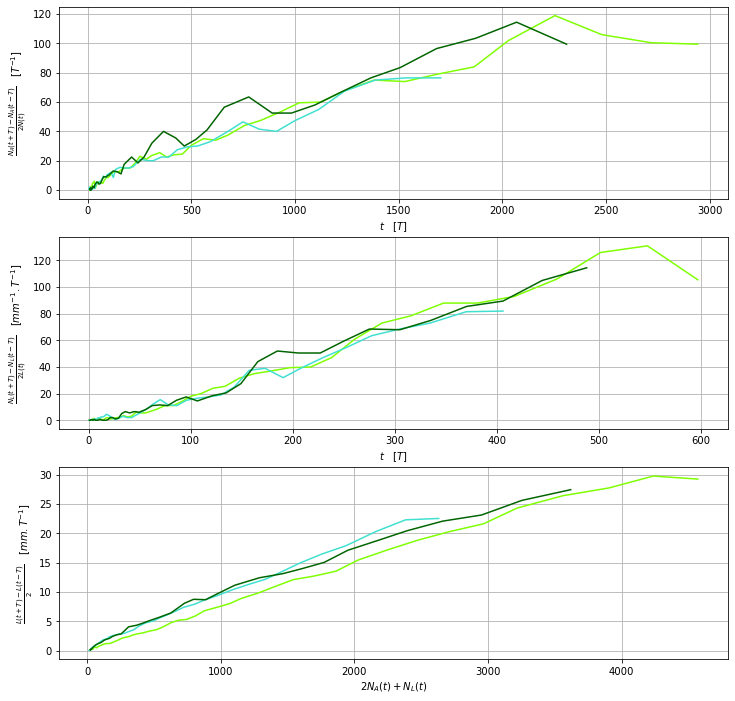

In [14]:
fig,axes = plt.subplots(figsize=(12,12),nrows=3)
for k,r in enumerate(reseaux_after_overlaps):
    L = mesures[r.name]["L"]
    tt = np.arange(r.start,r.end+1)
    api_start = np.array([b.get_tstart() for b in r.branches if b.nature == "Apical"])
    lat_start = np.array([b.get_tstart() for b in r.branches if b.nature == "Lateral"])
    count_api = np.array([np.sum(api_start<=t0) for t0 in tt])
    count_lat = np.array([np.sum(lat_start<=t0) for t0 in tt])
    count_N = count_api+count_lat
    
    dNa = (count_api[2:]-count_api[:-2])/2
    dNl = (count_lat[2:]-count_lat[:-2])/2
    ax = axes[0]
    ax.plot(count_N[1:-1],dNa,color=colors[k])
    ax = axes[1]
    ax.plot(L[1:-1]*1.6/1000,dNl,color=colors[k])
    ax = axes[2]
    dL = (L[2:]-L[:-2])/2
    ax.plot((2*count_api+count_lat)[1:-1],dL/1000,color=colors[k])
ax = axes[0]
ax.grid()
ax.set_xlabel("$t\quad[T]$")
ax.set_ylabel("$\\frac{N_A(t+T)-N_A(t-T)}{2N(t)}\quad[T^{-1}]$")
ax = axes[1]
ax.grid()
ax.set_xlabel("$t\quad[T]$")
ax.set_ylabel("$\\frac{N_L(t+T)-N_L(t-T)}{2L(t)}\quad[mm^{-1}.T^{-1}]$")
ax = axes[2]
ax.grid()
ax.set_xlabel("$2N_A(t)+N_L(t)$")
ax.set_ylabel("$\\frac{L(t+T)-L(t-T)}{2}\quad[mm.T^{-1}]$")
plt.show()
plt.close()
    